# 2.1. Деревья решений. Классификация

### Agenda:
* критерий информативности
* визуализация разделяющих поверхностей решения и визуализация самого дерева
* оценка важности фичей
* ужасы переобучения

## 1. Критерий информативности

как мы разобрали, построение дерева зависит от следующих факторов:
* вид правила разбиения
* критерий информативности
* критерий останова
* метод стрижки
* проблема пропусков

пройдёмся критериям информативности

In [82]:
import numpy as np
from collections import Counter

*Нам понадобятся две библиотеки: numpy вы знаете, а объект класса Counter в заданном списке просто подсчитывает количество вхождений каждого элемента и возвращает результат в виде словаря. Пример:*

In [83]:
Counter([9,9,9,7,7])

Counter({9: 3, 7: 2})

*Для численного измерения улучшения разбиений на каждом этапе мы вводим некоторый *критерий информативности*, который будет оценивать разнообразие объектов в выборке: чем больше разных классов в выборке, тем больше значение H(R). Чем меньше взвешенное значение критерия после разбиения - тем лучше*

Ниже представлена функция для расчёта энтропийного критерия качества:

$H(R) = -\sum_{k=1}^{K}p_klogp_k$

 ### **Задание.** Дополните функцию расчёта энтропийного критерия множества

In [84]:
def HEntropy(l):
    length = len(l) #определяем длину нашей выборки 
    cnt = Counter(l) #берем список значний
    
    ent = 0
    
    for cl in cnt.values(): #пробегаем по списку значений. Каждое значение это новый класс
        p = cl / length #для каждого из них (нового класса) считаем долю 
        l2 = np.log2(p) #потом считаем логорифм этой доли
        it = -p * l2 #Умножаем одно на другое 
        ent += it #и плюсуем к итоговому результату
    return ent #вот это вот значение возвращаем для нашей ф-ии


**Задание.** По аналогии с *энтропийным критерием* заполните функции *критерия Джини*

$Н(R) = -\sum_{k=1}^{K}p_k(1-p_k)$

In [85]:
def HGini(l):
    length = len(l) #определяем длину нашей выборки 
    cnt = Counter(l) #берем список значний
    
    gini = 0 
    
    for cl in cnt.values(): #пробегаем по списку значений. Каждое значение это новый класс
        p_1 = cl / length #для каждого из них (нового класса) считаем долю 
        p_2 = (1- p_1)
        it = p_1 * p_2
        gini += it 
    return gini #вот это вот значение возвращаем для нашей ф-ии
    
    

###  Information Gain
*Information Gain (IG)* - функционал качества, отвечающий на вопрос, а сколько энтропии мы погасили при определённом разбиении? На каждом шаге разбиения при построении дерева максимизируется IG. Формула для вычисления при критерии информативности H:

$IG(R) = H(R) - \frac{|R_l|}{|R|}H(R_l) - \frac{|R_r|}{|R|}H(R_r)$

### **Задание.** Заполните функцию для вычисления функционала качества

In [86]:
#Для просчета информационного выигрыша информейш гейн
def IG(H, l, i):
    # H ф-я информационного критерия
    #l - выборка 
    #i - номер того объекта, по которому происходит разделение. То, что попадет в левую часть, 
    #а то, что выше этого номера попадает в правую часть 
    
    left_l = l[:i] # получаем лувую выборку 
    right_l = l[i:] #получаем правую выборку
    
    return H(l) - (len(left_l) / len(l)) * H(left_l) - (len(right_l) / len(l)) * H(right_l)
    #H(l)  исходный информационный критерий
    #H(left_l) и H(right_l информационный криетрий левой и правой части 
    # len(left_l) / len(l) и (len(right_l) / len(l)доли
    # просто все по формуле  

### Тут функция для визуализации работы произвольного критерия качества на выборке

In [87]:
#Попробуем реализовать наши функции, которые мы написали 
def test_H(H, l):
    print("{:5} {:3}   {:4} {:4} {:4}".format("#","l","IG","Hl","Hr"))
    print("-"*24)
    i_max, IG_max = 0, 0
    for i in range(1,len(l)): #Перебераются все возможные пороги. Для простоты 1 признак у нас  
        print("{:2}. {:3}   {:.2f} {:.2f} {:.2f}".format(i, l[i], IG(H, l, i), H(l[:i]), H(l[i:])))
        if IG_max < IG(H, l, i): # выбираем, где у нас максимальный информешн гейн
            i_max, IG_max = i, IG(H, l, i)
    print(f' Далее после элемента: {i_max -1}')
        
        
        
        
        

Определим как-нибудь выборку и посмотрим, какое разбиение предложат критерии информативности. Замечу, что элементы здесь будут выводиться начиная со второго, а значения функций рассчитаны для разбиения *перед* элементом строки

In [88]:
#Вот такая вот выборка у нас. У нас будет 2 класса и мы их будем делить 
l = [1]*5 + [2]*3 + [1]*4
print(l)

[1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1]


In [89]:
test_H(HEntropy, l)

# # - это номер объекта 
# l - это номер классса 
# IG - информационный выигрыш 
# Hl - значение информационного критерия для левой части
# HR - значение информационного критерия для правой части 
# Деление после 4 элемента считается самым выигрышным (0.24)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.04 0.00 0.85
 2.   1   0.08 0.00 0.88
 3.   1   0.12 0.00 0.92
 4.   1   0.17 0.00 0.95
 5.   2   0.24 0.00 0.99
 6.   2   0.03 0.65 0.92
 7.   2   0.01 0.86 0.72
 8.   1   0.17 0.95 0.00
 9.   1   0.12 0.92 0.00
10.   1   0.08 0.88 0.00
11.   1   0.04 0.85 0.00
 Далее после элемента: 4


In [90]:
# Возьмем критерий джини. Аналогично после 4 элемента самое лучшее разбиение (0.09)
test_H(HGini, l)

#     l     IG   Hl   Hr  
------------------------
 1.   1   0.01 0.00 0.40
 2.   1   0.02 0.00 0.42
 3.   1   0.04 0.00 0.44
 4.   1   0.06 0.00 0.47
 5.   2   0.09 0.00 0.49
 6.   2   0.01 0.28 0.44
 7.   2   0.00 0.41 0.32
 8.   1   0.06 0.47 0.00
 9.   1   0.04 0.44 0.00
10.   1   0.02 0.42 0.00
11.   1   0.01 0.40 0.00
 Далее после элемента: 4


In [91]:
# Посмотрим, где будет второе разбиение самое хорошее
test_H(HGini, l[5:])

# Мы берем объекты старше 4  и выше и отдаем на проверку критерию джини

#     l     IG   Hl   Hr  
------------------------
 1.   2   0.11 0.00 0.44
 2.   2   0.26 0.00 0.32
 3.   1   0.49 0.00 0.00
 4.   1   0.28 0.38 0.00
 5.   1   0.15 0.48 0.00
 6.   1   0.06 0.50 0.00
 Далее после элемента: 2


## 2. Визуализация принятия решений классификатором sklearn

#### 1. Используем данные о цветках ириса из занятия

In [137]:
from sklearn.datasets import load_iris
import pandas as pd

In [138]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [139]:
iris = load_iris()

In [140]:
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.DataFrame(iris.target, columns=['species'])
df = pd.concat([X,y], axis=1) #Создаем наш датафрей

In [148]:
y.value_counts()

species
0          50
1          50
2          50
dtype: int64

In [96]:
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Выведем попарное распределение фичей датасета с раскраской по виду цветка

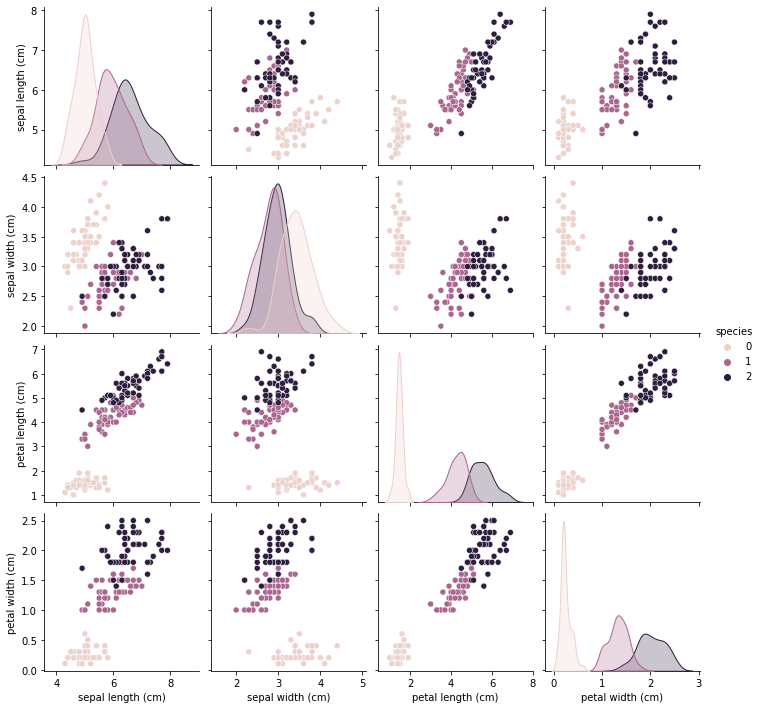

In [97]:
sns.pairplot(df, hue='species', diag_kind="kde")

Визуально кажется, что ширина листка (petal width) может самостоятельно отделить два класса друг от друга идеально. Для других двух классов понадобится еще хотя бы ещё одна фича.

Возьмём две фичи для возможности изобразить это в 2D: 
длину и ширину листка

In [163]:
Xcut = X[X.columns[2:4]] 
Xcut
#Чтобы красиво посмотреть на  разделение между 2 клссамами, мы оставим только 2 признака (длину и ширину)

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


#### 2. Используем классификатор

In [150]:
from sklearn.tree import DecisionTreeClassifier #импортируем наш классификатор дерева 

In [ ]:
# DecisionTreeClassifier

In [151]:
clf = DecisionTreeClassifier(max_depth=2)
# Создаем объект и говорим, что макс глубина дерева будет равна 2. Ограничиваем глубину дерева 2

In [152]:
# Обучаем нашу модель и передаем туда обрезанную выборку (2 признака)
clf.fit(Xcut, y)

DecisionTreeClassifier(max_depth=2)

In [165]:
# это просто тестовые значения поставим на предсказание и определения класса
clf.predict([ [1,1], [3,3] ])

array([1, 2])

In [157]:
df.species.unique() # можем посмотреть, какие у нас есть классы 

array([0, 1, 2])

In [164]:
clf.predict_proba([ [1,1], [3,3] ]) # вероятность классов быть отнесенными

array([[0.        , 0.90740741, 0.09259259],
       [0.        , 0.02173913, 0.97826087]])

In [161]:
clf.score(Xcut, y)

0.96

Визуализируем границу принятия решений. Для удобства все упаковано в функцию **test_clf**, в неё передаётся созданный классификатор и при установленном fit_clf=True обучается внутри, а затем отрисовывает границу. Таким образом можно экспериментировать с параметрами классификатора

In [105]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

In [106]:
def test_clf(clf, X, y,cy=0, fit_clf=False):
    xx,yy = get_grid(X.values)
    if fit_clf:
        clf.fit(X, y)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, predicted, cmap='Pastel1')
    plt.scatter(X.values[:, 0], X.values[:, 1], s=100, cmap='tab10',c=cy)
    if fit_clf:
        return clf

*попробуйте при разной глубине*

<ipython-input-106-ab1550250121>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, predicted, cmap='Pastel1')


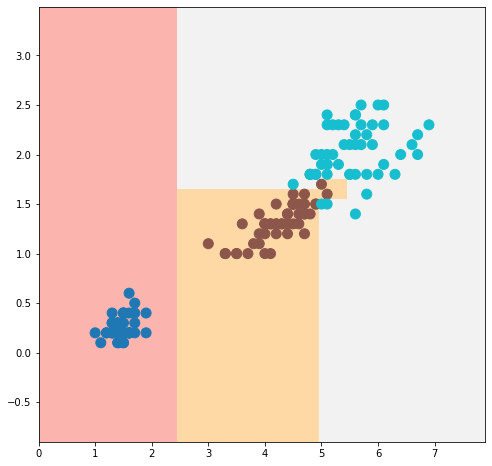

In [107]:
clf = test_clf(DecisionTreeClassifier(), Xcut, y,cy=y['species'].tolist(), fit_clf=True)

обратите внимание, один блок занимает то позицию снизу, то слева: данных недостаточно для принятия однозначного решения и экстраполяция идёт произвольно

#### 3. Визуализируем само дерево

Возможно, самое замечательное свойство одиночных деревьев - возможность визуализировать их алгоритм работы и затем объяснить его хоть человеку, хоть машине

Дерево можно как-то отобразить внутри ipython-ноутбука с помощью библиотеки pydot и установлнного webgraphviz, но мы воспользуемся скорее онлайн-сервисом http://www.webgraphviz.com

Сгенерируем код дерева в формате .dot и скопируем его на сайт

In [108]:
from sklearn.tree import export_graphviz
# Ф-я, которая получает граф
def get_tree_dot_view(clf, feature_names=None, class_names=None):
    print(export_graphviz(clf, out_file=None, filled=True, feature_names=feature_names, class_names=class_names))

In [109]:
# Еще раз обучаем и берем более глубокое измерение 3 
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(Xcut, y)

DecisionTreeClassifier(max_depth=3)

In [110]:
clf.feature_importances_

array([0.58561555, 0.41438445])

In [123]:
pip install pydotplus

     |████████████████████████████████| 278 kB 1.6 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=24ed7b8db4b6fa34d1bb6830acd14607a9b262f7feea61608837fbbdb919e9e9
  Stored in directory: /Users/dubrov_arseniy/Library/Caches/pip/wheels/fe/cd/78/a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus
Note: you may need to restart the kernel to use updated packages.


In [127]:
conda install graphviz

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [129]:
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#Теперь у нас в каждом из узлов есть:
#решающее правило
#чему равнялсся информационный критерий
# сколько было семплов
#сколько было семплов каждого класса

InvocationException: GraphViz's executables not found

In [ ]:
get_tree_dot_view(clf, list(Xcut.columns), iris.target_names)
#текстом граф 

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="petal width (cm) <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa", fillcolor="#ffffff"] ;
1 [label="gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa", fillcolor="#e58139"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor", fillcolor="#ffffff"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
3 [label="petal length (cm) <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor", fillcolor="#4de88e"] ;
2 -> 3 ;
4 [label="gini = 0.041\nsamples = 48\nvalue = [0, 47, 1]\nclass = versicolor", fillcolor="#3de684"] ;
3 -> 4 ;
5 [label="gini = 0.444\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica", fillcolor="#c09cf2"] ;
3 -> 5 ;
6 [label="petal length (cm) <= 4.85\ngini = 0.043\nsamples = 46\nvalue = [0, 1, 45]\nclass = virginica

-----

**Задание**
1. визуализировать дерево
2. вставить скрин с картинкой сюда в ipython notebook (!\[text](imagename.png))
3. проверить индексы Джини в узлах: совпадают с нашей расчётной функцией?
4. ветка налево - это True или False? что значит цвет узла? class? values?

-----

## 3. Оценка важности фичей

важность зависит от конкретного прогона классификатора, это не объективный показатель, но дающий представление

*попробуйте при разной глубине*

''

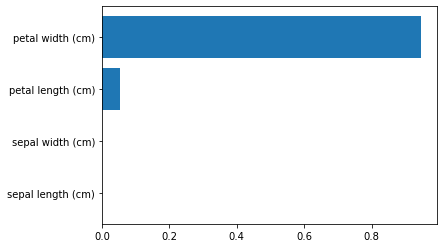

In [132]:
clf = DecisionTreeClassifier(max_depth=3)# Создадим наш классификатор
clf.fit(X, y)# Обучим наш классификатор

plt.barh(np.arange(len(clf.feature_importances_)), clf.feature_importances_)

#clf.feature_importances_ тут хранится важность наших признаков, Чем важнее признак, тем больше график

plt.yticks(np.arange(len(X.columns)),X.columns)
''

## 4. Переообучение наглядно

*здесь я использую генерацию датасета из [блога](https://habrahabr.ru/company/ods/blog/322534/) open data science*

In [133]:
np.seed = 7
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]
train_data = pd.DataFrame(train_data)

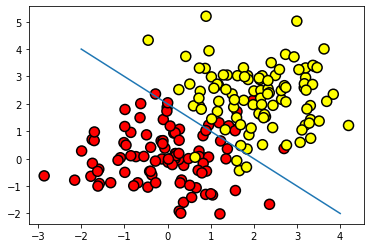

In [134]:
plt.scatter(train_data[0], train_data[1], c=train_labels, s=100, cmap='autumn', edgecolors='black', linewidth=1.5);
plt.plot(range(-2,5), range(4,-3,-1));

*попробуйте при разной глубине*

In [135]:
train_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

ValueError: 'c' argument has 150 elements, which is inconsistent with 'x' and 'y' with size 200.

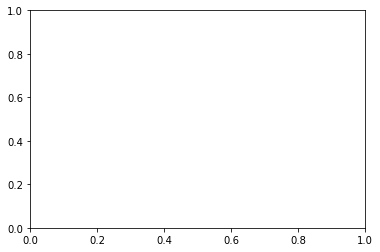

In [136]:
plt.scatter(train_data.values[:, 0], train_data.values[:, 1], s=100, cmap='tab10',c=y['species'].tolist())

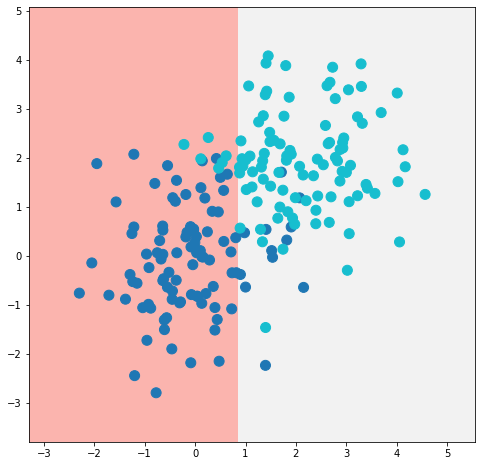

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=1), train_data, train_labels,cy=train_labels, fit_clf=True)

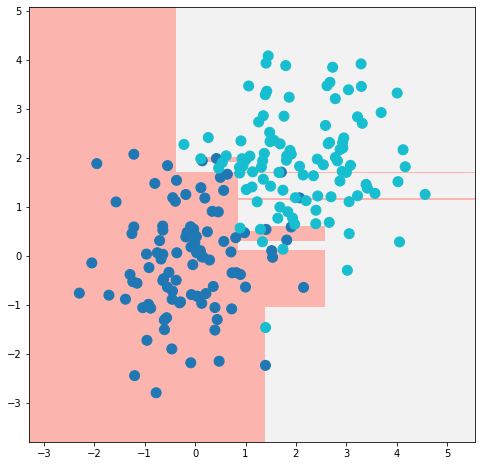

In [ ]:
clf = test_clf(DecisionTreeClassifier(), train_data, train_labels,cy=train_labels, fit_clf=True)

А здесь можно увидеть огромное переобученное дерево: http://www.webgraphviz.com

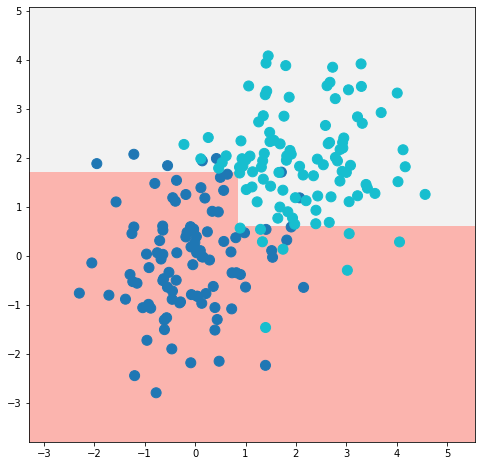

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=2), train_data, train_labels,cy=train_labels, fit_clf=True)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="x <= 0.849\ngini = 0.5\nsamples = 200\nvalue = [100, 100]", fillcolor="#ffffff"] ;
1 [label="y <= 1.731\ngini = 0.12\nsamples = 94\nvalue = [88, 6]", fillcolor="#e78a46"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="gini = 0.0\nsamples = 83\nvalue = [83, 0]", fillcolor="#e58139"] ;
1 -> 2 ;
3 [label="x <= -0.384\ngini = 0.496\nsamples = 11\nvalue = [5, 6]", fillcolor="#deeffb"] ;
1 -> 3 ;
4 [label="gini = 0.0\nsamples = 3\nvalue = [3, 0]", fillcolor="#e58139"] ;
3 -> 4 ;
5 [label="y <= 2.017\ngini = 0.375\nsamples = 8\nvalue = [2, 6]", fillcolor="#7bbeee"] ;
3 -> 5 ;
6 [label="x <= 0.444\ngini = 0.48\nsamples = 5\nvalue = [2, 3]", fillcolor="#bddef6"] ;
5 -> 6 ;
7 [label="x <= 0.127\ngini = 0.444\nsamples = 3\nvalue = [2, 1]", fillcolor="#f2c09c"] ;
6 -> 7 ;
8 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5"] ;
7 -> 8 ;
9 [label="gini = 0.0\nsamples = 2\nvalue = 

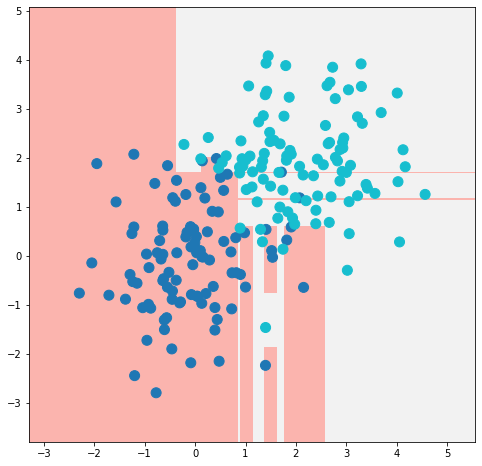

In [ ]:
clf = test_clf(DecisionTreeClassifier(max_depth=10), train_data, train_labels,cy=train_labels, fit_clf=True)
get_tree_dot_view(clf, feature_names=['x','y'])

## DecisionTreeRegression 

In [76]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

In [63]:
#Создадим рандомную выборку
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80,1), axis = 1)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

In [70]:
list_depth = [1,2,3,4,5,6,7] # Для переборки разной глубины нашего дерева

dt_regs = {}

for i in list_depth:
    dt_regs[f' depth = {i}'] = DecisionTreeRegressor(max_depth = i).fit(X, y)
    # для каждой разной глубины мы будем строить результат 
dt_regs['depth = inf'] = DecisionTreeRegressor().fit(X, y)
# Потом построи дереве, где глубина у нас вообще неограничена 
dt_regs['reg'] = DecisionTreeRegressor(min_samples_leaf = 3, criterion = 'mae').fit(X, y)
# Построим дерево, где буду дополнительные параметры 
#min_samples_leaf - кол-во объекотов, на которые можно разделять узел 3
#criterion средне абсолютная ошибка 

In [73]:
#Predict 
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

pred_list = {}
for key, cur_dt_reg in dt_regs.items():
    pred_list[key] = cur_dt_reg.predict(X_test)

IndexError: index 4 is out of bounds for axis 0 with size 4

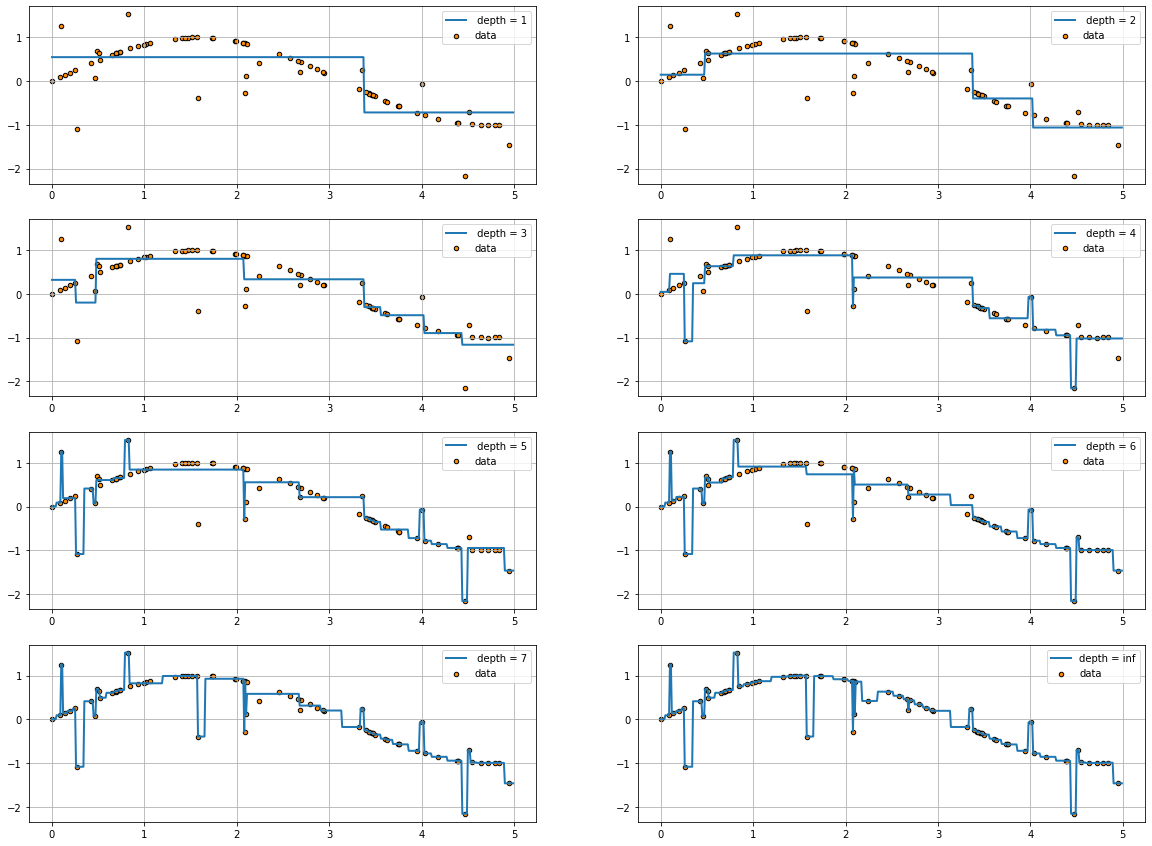

In [78]:
# Plot the results

fig, axa = plt.subplots(4,2, figsize = (20,15))
for i, (key, cur_pred) in enumerate(pred_list.items()):
    ax = axa[i // 2, i%2]
    ax.scatter(X, y, s = 20, edgecolor = 'black', c= 'darkorange', label = 'data')
    ax.plot(X_test, cur_pred, label = f'{key}', linewidth = 2)
    ax.grid()
    ax.legend()
    
fig.suptitle('Decision Tree Regression')
plt.show()


"""
На первом графике одно углубление и получается 2 листа (варианта)
на втором (верхний правый) углубление 2 и 4 варианта (полоски вверх вниз).
спустились еще на один уровень (3) получается 8 листьев 
4 уровень глубины получается 16 листьев. На 4 уровне мы замечаем, что начинается переобучение и стали реагировать 
на шумы (выборосы). До 4 уровня мы на это не обращали внимания модель 
на 5 уровне у нас еще больше реакция на эти выбросы 
чем гулбже, тем больше внимания на выбросы модель берет 

и когда мы посмотрим график бесконечности углубления, мы увидим, что наша модель зафиксировала каждый выброс
то есть через каждый объект обучающий  нашей выборки модель пробежала

Посмотрим последний график, когда мы наше дерево регулизировали. мы сказали, что можно разбивать объекты только тогда, 
когда их больше 3 и в качестве критерия взяли ср абсолютную ошибку, чтобы она не так сильно реагировала на выбросы
Мы видим, что дерево строить кривую, которая достаточно близка к исходной и при этом она не реагирует на выбросы

Настройки дерева и параметров это очень важно!!!



"""